# Preamble

In [1]:
%matplotlib notebook

## Notebook parameters

In [2]:
NAME = 'a_1_generate_filing_dataset'
PROJECT = 'covid-empirical'
PYTHON_VERSION = '3.9'
USER = 'Ties'
CONDA_ENVIRONMENT = 'covid-empirical'
USE_EXTERNAL_PIPELINE = True

## Run preamble script

In [3]:
%run -i preamble.py 

----------------------------------------------------------------------------------
The following utility functions are loaded and available through `functions.<..>`:
----------------------------------------------------------------------------------

extract_data_edgar_link, fast_load_json, fast_store_json, flatten_multiindex_column, inDB, recreate_edgar_link

----------------------------------------------------------------
The following modules and functions are imported by preamble.py:
----------------------------------------------------------------

copy, delayed, importlib, json, math, np, orjson, os, pd, plt, pqdm_p, pqdm_t, random, re, requests, sys, time, yaml


## Notebook specific imports

In [4]:
from datetime import datetime as dtime
import requests

----
# Get the WRDS data for the CIK codes
----

Note, the WRDS SEC Analytics Suite was not up to date at the time of running this code.   
To overcome that issue, we retrieve a list of CIK codes from WRDS and then retrieve the filings from the SEC EDGAR API.

## Get WRDS data

We retrieved the full list of filings from the `SEC Filings on WRDS` database in the `WRDS SEC Analytics Suite`. 

Specifically, we used the following parameters for the query in the web portal:

- Companies: search the entire database  
- Period start: Jan-01-2017  
- Period end: Aug-31-2021  
- Forms to include: 10-K or 10-Q
- Rest of the options as default
- Columns retrieved:
 - CIK  
 - FDATE  
 - FINDEXDATE  
 - LINDEXDATE  
 - FORM  
 - CONAME  
 - WRDSFNAME  
 - FSIZE  
 - DOCCOUNT 
 - FNAME  
 - RDATE  
 - SECADATE  
 - SECATIME  
 - SECPDATE  
 - ACCESSION  
 - REGCOUNT  
 - REGSEQ  
 - REGROLE  
 - REGCIK  
 - REGFILE_NO  
 - REGCONAME  
 - REGFYE  
 - REGSIC  
 - REGSTREET_HDQ  
 - REGCITY_HDQ  
 - REGSTATE_HDQ  
 - REGZIP_HDQ  
 - REGSTATE_INC  
 - REGPHONE  
 - REGFCONAME  
 - REGFCHANGEDATE  
 
Full Input parameters, submitted `2021-08-13 18:41`:

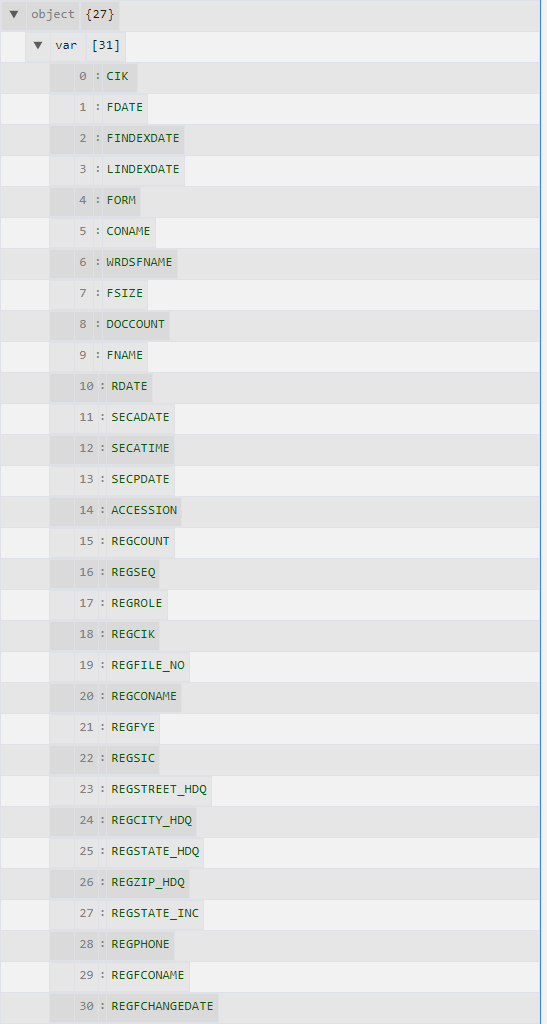
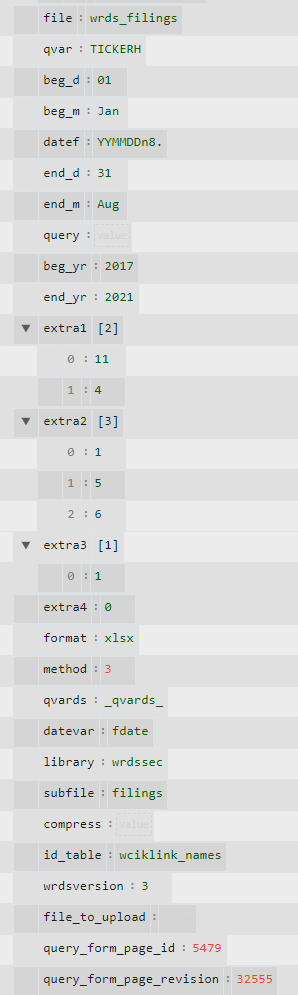

In [5]:
wrds_file = Path.cwd() / '0_data' / 'external' / 'wrds_all_10qk_filings_08132021.xlsx'
wrds_file.exists()

True

In [6]:
## Loading the Excel file is slow, to speed up development I save it as HDF as well.

speed_bypass_loc = pipeline / 'store' / 'wrds_df.h5'

if not speed_bypass_loc.exists: 
    wrds_df = pd.read_excel(wrds_file)

    ## Clean up
    wrds_col_dict = {
        'Filing Date' : 'filingDate', 
        'SEC Central Index Key' : 'cik', 
        'Form Type' : 'form',
        'Company Name' : 'compName',
        'SEC Acceptance Date' : 'acceptDate',
        'Conformed Period of Report' : 'reportDate',
        'Accession Number' : 'accessionNumber' 
    }

    wrds_df = wrds_df.rename(columns=wrds_col_dict)
    wrds_df = wrds_df[list(wrds_col_dict.values())]

    ### Add cik padded
    wrds_df['cik_padded'] = wrds_df['cik'].astype(str).str.zfill(10)

    ## Save to speed up
    wrds_df.to_hdf(speed_bypass_loc, 'wrds_df')
else:
    wrds_df = pd.read_hdf(speed_bypass_loc, 'wrds_df')

### Show data

In [9]:
print(f'Number of filings: {len(wrds_df):,}')

Number of filings: 196,434


In [45]:
wrds_df.head(5).T.head(25)

,0,1,2,3,4
filingDate,2017-03-31 00:00:00,2017-05-09 00:00:00,2017-08-09 00:00:00,2017-11-09 00:00:00,2018-03-12 00:00:00
cik,2178,2178,2178,2178,2178
form,10-K,10-Q,10-Q,10-Q,10-K
compName,"ADAMS RESOURCES & ENERGY, INC.","ADAMS RESOURCES & ENERGY, INC.","ADAMS RESOURCES & ENERGY, INC.","ADAMS RESOURCES & ENERGY, INC.","ADAMS RESOURCES & ENERGY, INC."
acceptDate,2017-03-31 00:00:00,2017-05-09 00:00:00,2017-08-09 00:00:00,2017-11-09 00:00:00,2018-03-12 00:00:00
reportDate,2016-12-31 00:00:00,2017-03-31 00:00:00,2017-06-30 00:00:00,2017-09-30 00:00:00,2017-12-31 00:00:00
accessionNumber,0000002178-17-000019,0000002178-17-000038,0000002178-17-000050,0000002178-17-000081,0000002178-18-000009
cik_padded,0000002178,0000002178,0000002178,0000002178,0000002178


# Update using SEC API

## Cik list

In [22]:
cik_list = wrds_df.cik_padded.unique()
print(len(cik_list))

9626


## Get the data

### Logic

In [23]:
edgar_api_endpoint = 'https://data.sec.gov/submissions/'

name = input(prompt = "Your name: ")
email = input(prompt = "Your email: ")
organization = input(prompt = "Your organization: ")

headers = {'User-Agent' : f'{name} - {organization} - {email}'} ## The SEC requires that you include this information in your user agent string

In [25]:
def get_filing(cik:str, get_older:bool = False, prnt_size:bool = False):
    res = requests.get(edgar_api_endpoint + 'CIK{}.json'.format(cik),
                      headers=headers)

    res_json = res.json()
    
    row = {'cik' : cik}
    for col in ['ein', 'category', 'fiscalYearEnd', 'stateOfIncorporation', 'phone', 'entityType', 'name', 'sic']:
        if col in res_json:
            row[col] = res_json[col]
        else:
            row[col] = np.nan

    ## Create a filing dataframe

    ### Newer filings

    filing_df = pd.DataFrame(res_json['filings']['recent'])

    ### Older filings

    if get_older:
        for json_link in res_json['filings']['files'][:5]:
            res_files = requests.get(edgar_api_endpoint + json_link['name'], headers=headers)
            res_files_json = res_files.json()
            older_filing_df = pd.DataFrame(res_files_json)
            filing_df = filing_df.append(older_filing_df)

    if prnt_size:
        print('There are {} filings in the dataframe.'.format(len(filing_df.index)))

    ### Drop columns not needed
    cols_to_keep = ['filingDate', 'reportDate', 'acceptanceDateTime', 'form', 'accessionNumber' , 'primaryDocument']
    filing_df = filing_df[cols_to_keep]

    row['df'] = filing_df

    return row

### Execute

In [ ]:
raw_api_list = []
fail_list = []
for cik in tqdm(cik_list):
    try:
        raw_api_list.append(get_filing(cik))
    except Exception as e:
        print(cik)
        fail_list.append({'cik' : cik, 'error' : e})

In [32]:
len(fail_list)

0

## Process API data

### Process

In [33]:
big_list = []
meta_list = []
for item in raw_api_list:
    ### Dataframes
    tmp_df = copy.deepcopy(item['df'])
    tmp_df['cik'] = item['cik']
    big_list += tmp_df.to_dict('records')
    
    ### Meta data
    ret_dict = {k : v for k,v in item.items() if k != 'df'}
    meta_list.append(ret_dict)

### Meta data

In [34]:
meta_df = pd.DataFrame(meta_list)

In [35]:
meta_df.to_stata(pipeline / 'out' / 'edgar_meta_df.dta')

### Dataframes

In [37]:
big_df = pd.DataFrame(big_list)

### Store

In [38]:
big_df.to_hdf(ePipeline / 'store' / 'big_df.h5', 'big_df')

## Just 10-KQ

In [51]:
big_df = pd.read_hdf(ePipeline / 'store' / 'big_df.h5')

In [52]:
big_10kq_df = big_df[big_df.form.isin(['10-Q', '10-K'])]

### Clean

In [56]:
big_10kq_df['acceptanceDateTime'] = pd.to_datetime(big_10kq_df['acceptanceDateTime'], utc=False)
big_10kq_df['acceptanceDateTime'] = big_10kq_df['acceptanceDateTime'].dt.tz_convert('EST')

In [57]:
big_10kq_df['acceptanceTime'] = big_10kq_df['acceptanceDateTime'].dt.time.astype(str)

big_10kq_df['acceptanceHour'] = big_10kq_df['acceptanceDateTime'].dt.hour

big_10kq_df['acceptanceMinute'] = big_10kq_df['acceptanceDateTime'].dt.minute

In [58]:
date_cols = ['filingDate', 'reportDate', 'acceptanceDateTime']
for col in date_cols:
    big_10kq_df[col] = pd.to_datetime(big_10kq_df[col])
    big_10kq_df[col] = big_10kq_df[col].dt.tz_localize(None)
    big_10kq_df[col] = big_10kq_df[col].dt.normalize()

In [59]:
big_10kq_df = big_10kq_df.rename(columns={'acceptanceDateTime' : 'acceptDate'})

In [60]:
big_10kq_df = big_10kq_df.drop('primaryDocument', axis=1)

In [61]:
big_10kq_df

,filingDate,reportDate,acceptDate,form,accessionNumber,cik,acceptanceTime,acceptanceHour,acceptanceMinute
2,2021-08-12,2021-06-30,2021-08-12,10-Q,0000002178-21-000077,0000002178,11:20:54,11,20
17,2021-05-06,2021-03-31,2021-05-06,10-Q,0000002178-21-000045,0000002178,11:27:41,11,27
21,2021-03-05,2020-12-31,2021-03-05,10-K,0000002178-21-000034,0000002178,10:07:36,10,7
43,2020-11-05,2020-09-30,2020-11-05,10-Q,0000002178-20-000135,0000002178,11:39:17,11,39
57,2020-08-06,2020-06-30,2020-08-06,10-Q,0000002178-20-000105,0000002178,11:35:59,11,35
...,...,...,...,...,...,...,...,...,...
4526704,2021-05-12,2021-03-31,2021-05-11,10-Q,0001835591-21-000006,0001835591,16:11:36,16,11
4526756,2021-08-13,2021-06-30,2021-08-13,10-Q,0001837671-21-000012,0001837671,11:16:37,11,16
4526767,2021-05-12,2021-03-31,2021-05-12,10-Q,0001837671-21-000004,0001837671,11:15:50,11,15
4526805,2021-08-06,2021-06-30,2021-08-06,10-Q,0001837686-21-000011,0001837686,11:05:59,11,5


### Save

In [62]:
big_10kq_df.to_hdf(ePipeline / 'store' / 'big_10kq_df.h5', 'big_10kq_df')

----
# Reconcile
----

## Clean WRDS

In [63]:
ADD_WRDS = False

In [64]:
if ADD_WRDS:
    wrds_df = wrds_df.drop(['cik'], axis=1)

    wrds_df = wrds_df.rename(columns={'cik_padded' : 'cik'})

    wrds_df['source'] = 'wrds'

    ## Join

    big_10kq_df['source'] = 'edgar'

    full_df = wrds_df.append(big_10kq_df)
else:
    full_df = big_10kq_df.copy()

In [65]:
full_df = full_df.drop_duplicates(subset = 'accessionNumber')

### Save

In [66]:
full_df.to_stata(pipeline / 'store' / 'full_10kq_df.dta')

### Load

In [ ]:
full_df = pd.read_stata(pipeline / 'store' / 'full_10kq_df.dta')

------
# Create primary dataset
------

## Limit to 2017 and later

In [67]:
full_17to21_df = full_df[full_df.filingDate > pd.to_datetime('1-1-2017')]

In [68]:
full_17to21_df = full_17to21_df.reset_index(drop=True)

In [70]:
full_17to21_df = full_17to21_df.drop('compName', axis=1, errors='ignore')

## Sort values

In [71]:
full_17to21_df = full_17to21_df.sort_values(['cik', 'filingDate'])

## Create variables

### Delay

In [73]:
full_17to21_df['secDelay'] = (full_17to21_df['filingDate'] - full_17to21_df['reportDate']).dt.days

### Add previous delay

In [74]:
tmp_list = []
for name, df in tqdm(full_17to21_df.groupby('cik')):
    
    df_10q = df[df.form == '10-Q'].sort_values('filingDate')
    df_10k = df[df.form == '10-K'].sort_values('filingDate')

    df_10q['previous_delay'] = df_10q.secDelay.shift(1)
    df_10k['previous_delay'] = df_10k.secDelay.shift(1)
    
    df_10q['previous_fdate'] = df_10q.filingDate.shift(1)
    df_10k['previous_fdate'] = df_10k.filingDate.shift(1)
    
    tmp_list += df_10q.append(df_10k).to_dict('records')

  0%|          | 0/9353 [00:00<?, ?it/s]

In [75]:
full_17to21_df = pd.DataFrame(tmp_list)

### Add delay relative to same Q last year

In [76]:
tmp_list = []
for name, df in tqdm(full_17to21_df.groupby('cik')):
    df_10q = df[df.form == '10-Q'].sort_values('filingDate')
    df_10k = df[df.form == '10-K'].sort_values('filingDate')
    
    tmp_list_2 = []
    for index, filing_item in df_10q.iterrows():
        window_one_side = 25
        hit_df = df_10q[
            (df_10q.filingDate < filing_item.filingDate - pd.to_timedelta('{} days'.format(365 - window_one_side))) & 
            (df_10q.filingDate > filing_item.filingDate - pd.to_timedelta('{} days'.format(365 + window_one_side))) &
            (df_10q.accessionNumber != filing_item.accessionNumber)
              ]
        
        ret_dict = {
            'accessionNumber' : filing_item['accessionNumber'],
            'same_q_last_fdate' : np.nan,
            'same_q_last_delay' : np.nan
        }
        
        if len(hit_df) > 0:
            ret_dict['same_q_last_fdate'] = hit_df.iloc[0]['filingDate']
            ret_dict['same_q_last_delay'] = hit_df.iloc[0]['secDelay']
         
        tmp_list_2.append(ret_dict)
        
    ## Merge back
    if tmp_list_2:
        tmp_df = pd.DataFrame(tmp_list_2)
        df_10q = pd.merge(df_10q, tmp_df, on='accessionNumber', how='left')
    
    ## Join with 10K and return
    tmp_list += df_10q.append(df_10k).to_dict('records') 

  0%|          | 0/9353 [00:00<?, ?it/s]

In [77]:
full_17to21_df = pd.DataFrame(tmp_list)

Add 10k, which is the same as the other delay

In [78]:
full_17to21_df['same_q_last_fdate'] = full_17to21_df.apply(lambda row: row['previous_fdate'] if row['form'] == '10-K' else row['same_q_last_fdate'], axis=1)

In [79]:
full_17to21_df['same_q_last_delay'] = full_17to21_df.apply(lambda row: row['previous_delay'] if row['form'] == '10-K' else row['same_q_last_delay'], axis=1)

## Calculate difference

In [80]:
full_17to21_df['change_to_last'] = full_17to21_df['secDelay'] - full_17to21_df['previous_delay']
full_17to21_df['change_to_last_same_q'] = full_17to21_df['secDelay'] - full_17to21_df['same_q_last_delay']

## Outliers

In [81]:
full_17to21_df = full_17to21_df.dropna(subset=['secDelay'])

In [82]:
full_17to21_df['outlier'] = full_17to21_df.secDelay > 100

## Save

### To Stata

In [83]:
full_17to21_df.to_stata(pipeline / 'out' / 'full_17to21_df.dta', write_index = False)

### To Excel

In [11]:
full_17to21_df.to_excel(pipeline / 'out' / 'full_17to21_df.xlsx')